In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from gap_statistic import OptimalK
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
import os
import glob

In [107]:
# Read in the PCA dataset and set the index
df = pd.read_csv('full_dataset_with_PCA.csv')
df.set_index(['Season', 'Player'], inplace=True)

In [109]:
values = df.values

# Create the model
n_clusters = 12
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

# Fit the model
cluster_labels = clustering.fit_predict(values)

# Step 3: Assign clusters back to the DataFrame
df['Cluster'] = cluster_labels + 1

In [110]:
df

PC1        PC2        PC3        PC4        PC5  \
Season Player                                                                  
2001   A.C. Green       1.151785  13.788141  -6.838558  -5.730690  -3.069604   
       A.J. Guyton     -3.462249  16.516936  -6.318832  -5.678356  -3.188951   
       Aaron McKie     -3.112862  19.986989  -5.405636  -5.874836  -3.012271   
       Aaron Williams   2.455642  17.472834  -7.826710  -6.810085  -3.958020   
       Adam Keefe       2.344406  11.770478  -5.366970  -4.743499  -2.589224   
...                          ...        ...        ...        ...        ...   
2019   Zaza Pachulia    3.068854  15.611814  -5.331242  -4.742522  -2.907456   
       Zhaire Smith    -2.079390  17.082990  -6.439016  -6.223070  -3.699687   
       Zhou Qi        -10.105444  42.912116 -22.560075 -19.891632 -10.986258   
       Álex Abrines    -1.539472  12.414182  -5.927378  -5.379327  -3.196213   
       Ángel Delgado    2.176621  16.750576  -8.469802  -7.854020  -3.234028   

                       Cluster  
Season Player                   
2001   A.C. Green            1  
       A.J. Guyton           2  
       Aaron McKie           7  
       Aaron Williams        5  
       Adam Keefe            1  
...                        ...  
2019   Zaza Pachulia         1  
       Zhaire Smith          2  
       Zhou Qi              11  
       Álex Abrines          1  
       Ángel Delgado         5  

[8870 rows x 6 columns]

In [112]:
# Read in the raw data to analyze how the averages for different clusters
pre_pca = pd.read_csv('full_dataset_before_PCA.csv')
pre_pca.set_index(['Season', 'Player'], inplace=True)
pre_pca['Cluster'] = cluster_labels + 1

In [113]:
# Sort by cluster to see the median value of each statistic for each cluster
cluster_medians = pre_pca.reset_index(drop=True).groupby('Cluster').median()

In [114]:
cluster_medians

,USG%,FGA,Personal Fouls Committed,BLK,STL,DRB,ORB,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Shooting Fouls Drawn,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,Dunks - %FGA
Cluster,,,,,,,,,,,,,,,,,,,,
1,13.0,10.332468,5.435762,1.048332,1.254609,6.522841,3.198555,1.942857,2.030427,0.000,0.667,0.293,1.263158,0.0500,0.0220,0.118,0.077,0.138,0.3930,0.058
2,16.5,14.271206,4.077736,0.575612,1.370885,5.259002,1.452214,1.989959,2.690614,0.956,0.625,0.200,1.164412,0.3260,0.3820,0.177,0.075,0.094,0.2295,0.024
3,25.2,20.955882,3.389292,0.351220,1.613445,4.356688,0.995046,3.510018,6.545455,0.763,0.323,0.267,2.169492,0.1720,0.2820,0.218,0.113,0.124,0.2370,0.008
4,9.4,6.740426,6.390533,0.920548,1.178648,6.109091,3.068731,1.812766,1.862687,0.000,0.628,0.300,0.808421,0.0000,0.0000,0.043,0.061,0.124,0.4850,0.031
5,17.1,13.425564,6.115426,1.836314,1.111066,8.450748,4.363636,2.553475,1.729412,0.000,0.669,0.352,2.133333,0.0000,0.0030,0.102,0.108,0.209,0.4670,0.105
6,21.3,18.155024,3.828902,0.519548,1.410886,5.251836,1.473900,2.520000,3.174935,0.925,0.556,0.234,1.811038,0.2650,0.3080,0.208,0.099,0.114,0.2400,0.027
7,19.3,15.485894,3.789603,0.276061,1.693097,3.876121,0.809924,3.109461,6.761466,0.802,0.335,0.231,1.325531,0.2005,0.3115,0.211,0.090,0.109,0.2375,0.002
8,30.7,25.158245,3.389513,0.792102,1.530435,7.137589,1.683140,3.978378,5.431579,0.667,0.413,0.361,3.776169,0.0970,0.1900,0.209,0.129,0.141,0.2860,0.033
9,15.1,12.000000,4.116996,0.257944,1.814634,3.847773,0.810230,2.948730,7.182022,0.857,0.375,0.215,0.862004,0.2030,0.3130,0.222,0.088,0.096,0.2220,0.000


In [124]:
pre_pca[pre_pca['Cluster'] == 11]

USG%        FGA  Personal Fouls Committed  \
Season Player                                                            
2005   Jackie Butler         53.7  37.440000                  0.000000   
2007   Von Wafer             46.2  48.000000                  0.000000   
2008   Marcus Williams       25.7  80.666667                 14.666667   
2014   DeAndre Liggins       47.8  48.000000                  0.000000   
2018   Chris Boucher         43.9  48.000000                  0.000000   
       Mindaugas Kuzminskas  43.7  48.000000                  0.000000   
       Naz Mitrou-Long       45.0  48.000000                  0.000000   
2019   Donte Grantham        40.7  50.400000                  0.000000   
       Terrence Jones        47.2  38.400000                  9.600000   
       Tyler Davis           40.7  48.000000                  0.000000   
       Zhou Qi               43.4  48.000000                  0.000000   

                                  BLK       STL        DRB   ORB        TOV  \
Season Player                                                                 
2005   Jackie Butler         0.000000  8.640000   0.000000   0.0   8.640000   
2007   Von Wafer             0.000000  0.000000   0.000000   0.0   0.000000   
2008   Marcus Williams       1.466667  7.333333  23.466667   4.4  20.533333   
2014   DeAndre Liggins       0.000000  0.000000   0.000000  48.0   0.000000   
2018   Chris Boucher         0.000000  0.000000  48.000000   0.0   0.000000   
       Mindaugas Kuzminskas  0.000000  0.000000   0.000000   0.0   0.000000   
       Naz Mitrou-Long       0.000000  0.000000   0.000000   0.0   0.000000   
2019   Donte Grantham        0.000000  0.000000   0.000000   0.0   0.000000   
       Terrence Jones        0.000000  0.000000  38.400000   0.0   9.600000   
       Tyler Davis           0.000000  0.000000   0.000000  48.0   0.000000   
       Zhou Qi               0.000000  0.000000   0.000000   0.0   0.000000   

                                   AST  % of FG Ast'd - 3P  ...   FTr  \
Season Player                                               ...         
2005   Jackie Butler          0.000000                 0.0  ...  0.50   
2007   Von Wafer              0.000000                 0.0  ...  0.00   
2008   Marcus Williams       38.133333                 0.0  ...  0.00   
2014   DeAndre Liggins        0.000000                 0.0  ...  0.00   
2018   Chris Boucher          0.000000                 0.0  ...  0.00   
       Mindaugas Kuzminskas   0.000000                 0.0  ...  0.00   
       Naz Mitrou-Long        0.000000                 1.0  ...  0.00   
2019   Donte Grantham         0.000000                 0.0  ...  0.00   
       Terrence Jones         0.000000                 0.0  ...  0.25   
       Tyler Davis            0.000000                 0.0  ...  0.00   
       Zhou Qi                0.000000                 0.0  ...  0.00   

                             Shooting Fouls Drawn  Corner 3s - %3PA  \
Season Player                                                         
2005   Jackie Butler                         19.2               0.0   
2007   Von Wafer                              0.0               0.0   
2008   Marcus Williams                        0.0               0.0   
2014   DeAndre Liggins                        0.0               0.0   
2018   Chris Boucher                          0.0               1.0   
       Mindaugas Kuzminskas                   0.0               0.0   
       Naz Mitrou-Long                        0.0               0.0   
2019   Donte Grantham                         0.0               0.0   
       Terrence Jones                         9.6               0.0   
       Tyler Davis                            0.0               0.0   
       Zhou Qi                                0.0               0.0   

                             % of FGA by Distance - 3P  \
Season Player                                            
2005   Jackie Butler                            

In [116]:
# Drop the indexes and convert DataFrame to NumPy array
pca_data = df.reset_index(drop=True)
data_array = pca_data.values

def optimalK(data, max_clusters):
    results = []  # List to hold results
    
    nrefs=5
    gaps = np.zeros((len(range(1, max_clusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, max_clusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
            clusters = ward.fit_predict(randomReference)
            
            # Calculate centroids for each cluster
            centroids = np.array([randomReference[clusters == j].mean(axis=0) for j in range(k)])

            # Calculate the sum of squared distances (similar to inertia)
            _, distances = pairwise_distances_argmin_min(randomReference, centroids)
            ward_inertia = np.sum(distances ** 2)
            
            refDisp = ward_inertia
            refDisps[i] = refDisp
        
        # Fit cluster to original data and create dispersion
        ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
        clusters = ward.fit_predict(data)
        
        # Calculate centroids for each cluster
        centroids = np.array([data[clusters == j].mean(axis=0) for j in range(k)])

        # Calculate the sum of squared distances (similar to inertia)
        _, distances = pairwise_distances_argmin_min(data, centroids)
        ward_inertia = np.sum(distances ** 2)
        
        origDisp = ward_inertia
        
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        results.append({'clusterCount': k, 'gap': gap})  # Append the results to the list
        resultsdf = pd.DataFrame(results)
    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [117]:
k, gapdf = optimalK(data_array, max_clusters=20)
print('Optimal k is: ', k)

Optimal k is:  19


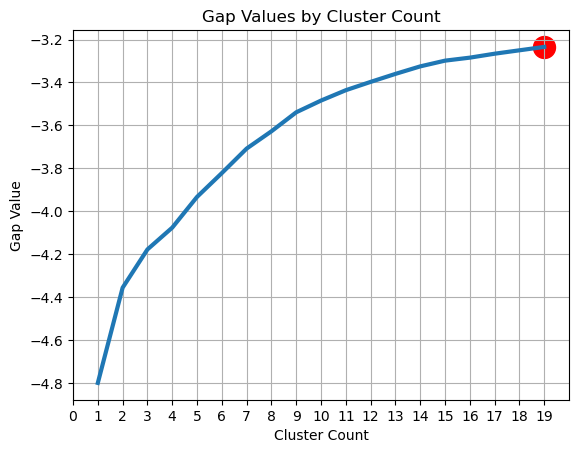

In [118]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlim(0, max(gapdf.clusterCount + 1))
plt.xticks(np.arange(0, max(gapdf.clusterCount) + 1, 1))
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()